# ME 234B Prelab 3b1 simulation

### To Do
- Threshold input


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import getUProportional as gu

## Auxiliary functions

Text(0.5, 1.0, 'Test plotting functions')

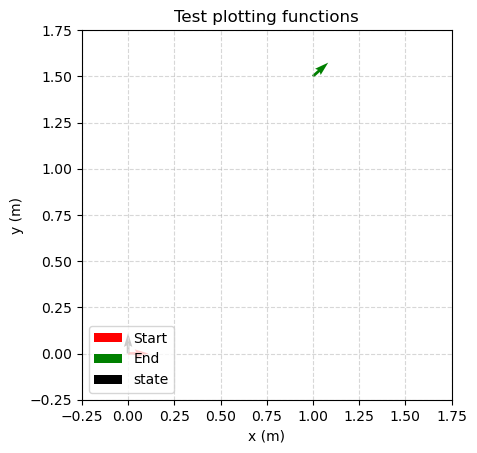

In [174]:
def initPlotSpace():
    plt.xlim([-1/4, 1.75])
    plt.ylim([-1/4, 1.75])
    plt.grid(alpha=0.5, ls="--")
    plt.gca().set_aspect('equal')
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")

def plotState(vecx, color='black', label="", alpha = 1):
    xy_start = vecx[0], vecx[1]
    xy_end = [vecx[0] + np.cos(vecx[2]),
        vecx[1] + np.sin(vecx[2])]
    plt.quiver(*xy_start, *xy_end, color=color, label=label, alpha=alpha)

plt.figure()
vecx = np.array([0, 0, np.pi/2])

vecx_0 = np.array([0,0,0])
vecx_f = np.array([1, 1.5, np.pi/12])

initPlotSpace()
plotState(vecx_0, color="red", label="Start")
plotState(vecx_f, color="green", label="End")
plotState(vecx, label="state")
plt.legend(loc="lower left")
plt.title("Test plotting functions")

## Kinematic simulation

$$
\vec{x} = [x, y, \theta]^T\\
\vec{x}_{t+1}=
\begin{bmatrix}
    x + (V \cdot \cos(\theta)\cdot\delta t)\\
    y + (V \cdot \sin(\theta)\cdot\delta t)\\
    \theta + \omega\cdot\delta t\\
\end{bmatrix}
\\
\Delta \vec x_2 = 0.1m\\
\Delta\theta_\mathrm{abs} = 10^\circ\\
\vec x_0 = [x_0, y_0, \theta_0]^T = [0, 0, 0]\\
\vec x_f = [x_f, y_f, \theta_f]^T = [1, 1.5, \pi/2]\\
$$
Do zero-order hold of 10Hz

In [11]:
def getNextState(vecx_0, vecu, dt):
    assert vecx_0.shape == (3,)
    assert vecu.shape == (2,)
    
    
    x_0, y_0, theta_0 = vecx_0
    V, omega = vecu
    
    vecx_1 = np.array([
        x_0 + V*np.cos(theta_0)*dt,
        y_0 + V*np.sin(theta_0)*dt,
        theta_0 + omega*dt
    ])
    
    return vecx_1

In [195]:
def simulate(K_h=-0.9, K_p=-0.9):
    THETA_TOL_DEG = 10 # degrees
    V_MAX = 0.5 # m/s
    OMEGA_MAX = np.pi/3 # rad/s
    
    vecx_0 = np.array([0,0,0])
    vecx_f = np.array([1, 1.5, np.pi/2])
    xy_tol = 0.1 # meters
    theta_tol = THETA_TOL_DEG*np.pi/180
    t = 0
    dt = 0.1 # seconds, corresp to 10 Hz
    t_max = 100
    k = 0
    k_max = int(t_max/dt)

    vecx = vecx_0
    xy_err_l2s = np.zeros((k_max,))
    theta_errs = np.zeros((k_max,))
    vecxs = np.zeros((3, k_max))
    vecus = np.zeros((2, k_max))
    ts = np.zeros((k_max,))

    while (k < k_max):
        xy_err_l2 = np.linalg.norm(vecx_f[:-1] - vecx[:-1])
        theta_err = vecx_f[-1] - vecx[-1]
        theta_err_abs = np.abs(theta_err)

        vecu = gu.getUProportional(vecx_0 = vecx, vecx_f = vecx_f,
                                   xy_tol=xy_tol, theta_tol=theta_tol,
                                  xy_err_l2 = xy_err_l2,
                                  theta_err_abs=theta_err_abs,
                                  K_h=K_h,K_p=K_p)
        vecu[0] = np.sign(vecu[0])*min(abs(vecu[0]), V_MAX)
        vecu[1] = np.sign(vecu[1])*min(abs(vecu[1]), OMEGA_MAX)
        assert abs(vecu[0]) <= V_MAX, "%f > %f"%(abs(vecu[0]), V_MAX)
        
        vecx = getNextState(vecx_0=vecx, vecu=vecu, dt=dt)

        theta_errs[k] = theta_err
        xy_err_l2s[k] = xy_err_l2
        vecxs[:, k] = vecx
        vecus[:, k] = vecu
        ts[k] = t

        k += 1
        t += dt


        if np.isclose(vecu, np.zeros((2,))).all():
            break

    theta_errs = theta_errs[:k]
    xy_err_l2s = xy_err_l2s[:k]
    vecxs = vecxs[:,:k]
    vecus = vecus[:,:k]
    ts = ts[:k]
    results = {
        'theta_errs':theta_errs,
        'xy_err_l2s':xy_err_l2s,
        'vecxs':vecxs,
        'vecus':vecus,
        'ts':ts,
        'K_h':K_h,
        'K_p':K_p}
    return results

In [85]:
vecx_f[-1]

1.5707963267948966

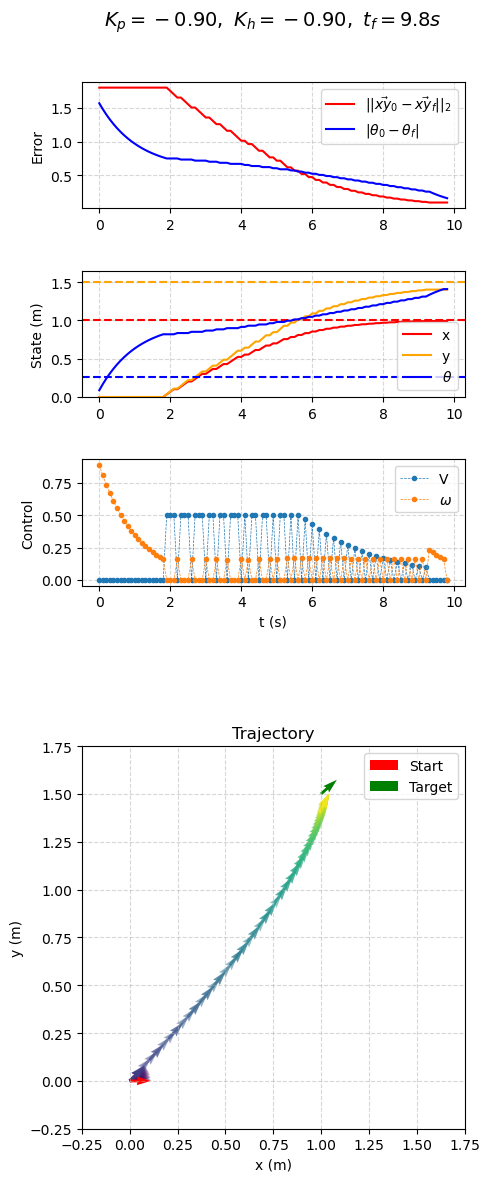

In [200]:
def plotResults(results):
    N_rows = 6
    K_h = results['K_h']
    K_p = results['K_p']
    vecxs = results['vecxs']
    vecus = results['vecus']
    xy_err_l2s = results['xy_err_l2s']
    theta_errs = results['theta_errs']
    ts = results['ts']

    fig = plt.figure(figsize=(5, 12))
    plt.subplot(N_rows,1,1)

    plt.plot(ts, xy_err_l2s,color='red', label="$||\\vec{xy}_0 - \\vec{xy}_f||_2$")
    plt.ylabel("Error")
    plt.plot(ts, theta_errs, color='blue', label="$|\\theta_0-\\theta_f|$")
    plt.grid(alpha=0.5, which='both', axis='both', ls='--')
    plt.legend()
    plt.title("$K_p=%.2f,\\ K_h=%.2f,\\ t_f=%.1fs$\n\n"%(K_p, K_h, ts[-1]),
             fontsize=14)

    plt.subplot(N_rows,1,2)
    colors = ["red", "orange", "blue"]
    labels = ["x", "y", "$\\theta$"]
    for k, val in enumerate(vecx_f):
        plt.plot(ts, vecxs[k,:], color=colors[k], label=labels[k])
        plt.axhline(val, color=colors[k], ls="--")
    plt.legend()
    plt.grid(alpha=0.5, ls='--')
    plt.ylim([0, max(abs(vecx_f)*1.1)])
    plt.ylabel("State (m)")

    plt.subplot(N_rows,1,3)
    plt.plot(ts, vecus.T, ls="--", lw=0.5, marker=".")
    plt.grid(alpha=0.5, ls='--')
    plt.legend(['V', '$\\omega$'])
    plt.xlabel("t (s)")
    plt.ylabel("Control")

    plt.subplot(2,1,2)
    initPlotSpace()
    K = len(ts)
    for k in range(K):
        color = (k/K, k/K, k/K)
        vecx = vecxs[:,k]
        plotState(vecx, alpha=0.5, color=mpl.cm.viridis(k/K))
    plotState(vecx_0, color="red", label="Start")
    plotState(vecx_f, color="green", label = "Target")
    plt.legend()
    plt.title("Trajectory")

    plt.tight_layout()
    
    return fig

results = simulate()
fig = plotResults(results)

0 3
1 3
2 3


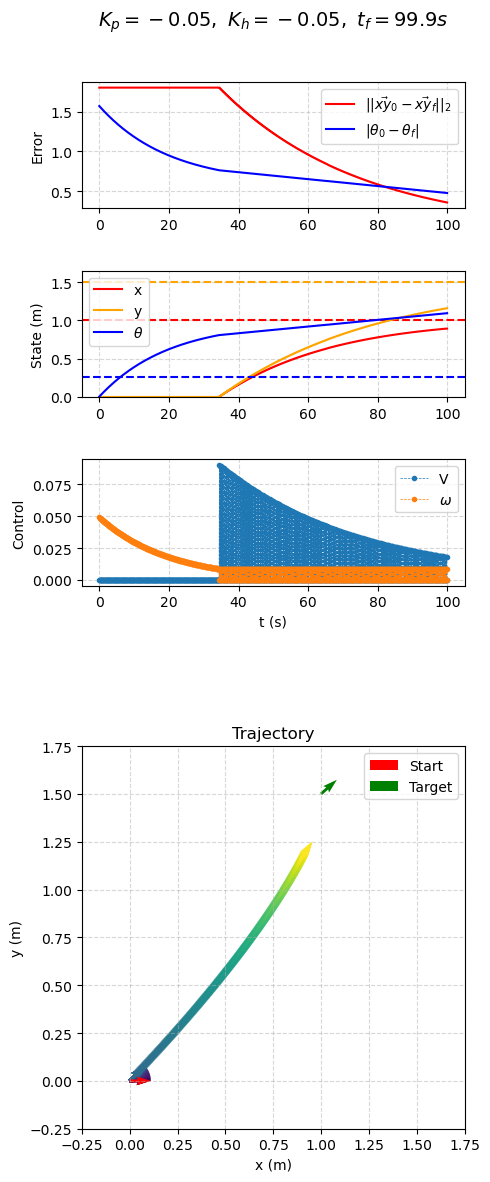

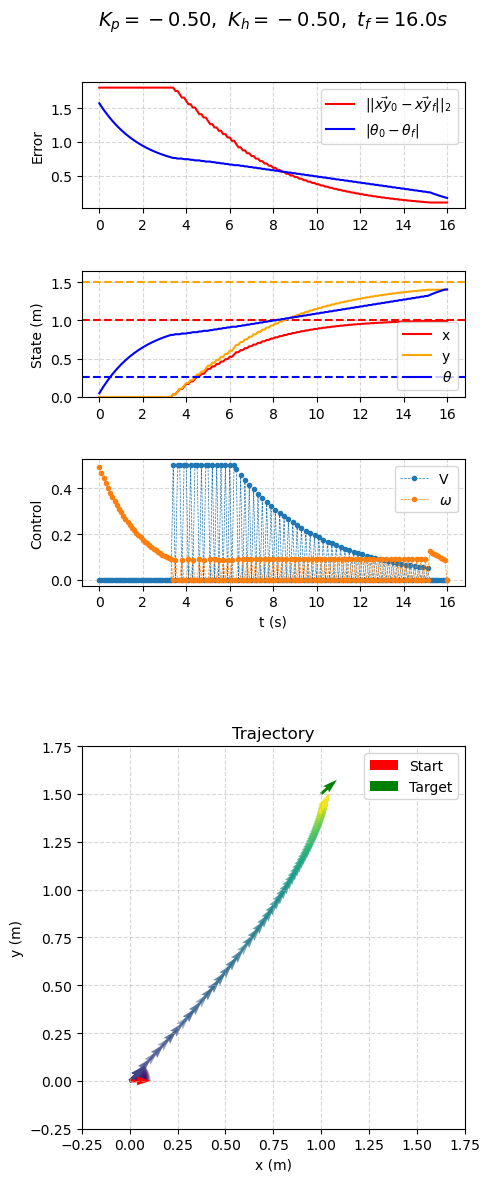

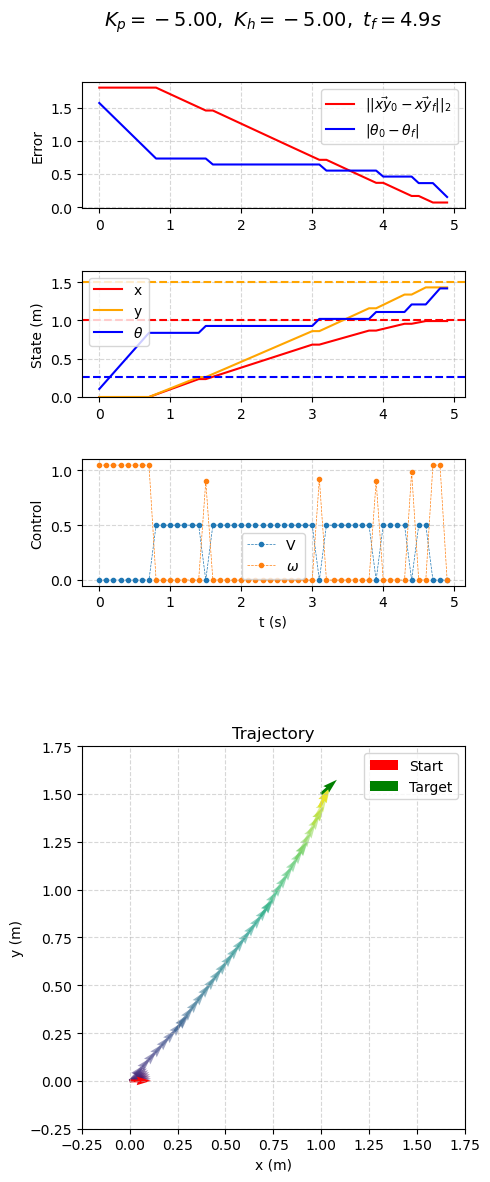

In [201]:
Ks = [-0.05, -0.5, -5]
results_all = {}
for k, K in enumerate(Ks):
    results = simulate(K_h = K, K_p = K)
    results_all[K] = results
    fig = plotResults(results)
    fig.savefig('results_K=%.1f.png'%K)
    print(k, len(Ks))